## TF reporter activity analysis

### Figure 1&2 - Characterizing the measured TF reporter activities across cell types

---
Load libraries

In [3]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_3592734/808305366.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data frames**

In [4]:
# Import processed bc counts from the preprocessing step
cDNA_df = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv")

# We are not going to use NIH3T3 data, so remove it for now
cDNA_df = cDNA_df[cDNA_df['cell'] != "NIH3T3"]

# Rename stimulation status of control conditions
cDNA_df['stimulation'].fillna("no", inplace=True)

# Load RNA-seq data
tf_rna = pd.read_csv("/DATA/usr/m.trauernicht/data/RNA_seq/rna_tpm_all_tfs.tsv", sep='\t')

# Prepare data frame for following analyses
cDNA_df2 = cDNA_df.copy()
cDNA_df2['tf'] = cDNA_df2['tf'].str.replace('_.*', '', regex=True)
cDNA_df2 = cDNA_df2.loc[
    (cDNA_df2['neg_ctrls'] == "No") &
    (cDNA_df2['hPGK'] == "No") &
    (~cDNA_df2['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df2['native_enhancer'] == "No")]
cDNA_df2 = cDNA_df2[['tf', 'condition', 'stimulation', 'reference_condition', 'tf_target', 'effect_size', 'off_target', 'cell', 'reporter_id', 'commercial_reporter', 'reporter_activity_minP', 'gcf', 'reporter_dif_minP']]
cDNA_df2['reporter_activity_minP'] = cDNA_df2['reporter_activity_minP'].apply(lambda x: np.log2(x))
cDNA_df2 = cDNA_df2.drop_duplicates()

#cDNA_df2

---
### Plot activity distribution for TF reporters vs. mutated reporters per cell type

Aim: Show that TFBS reporters are more active than mutated TFBS reporters.

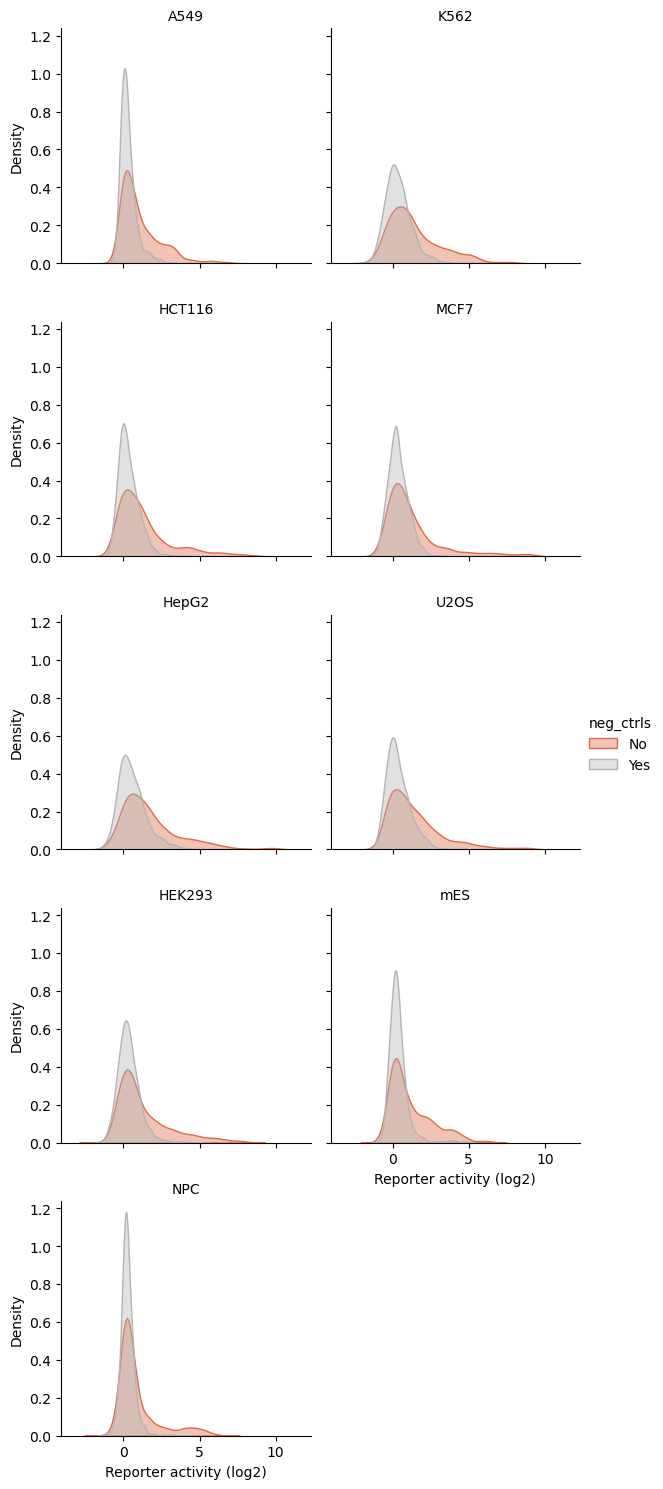

In [3]:
# Filter and transform cDNA_df
cDNA_df2 = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')
]
cDNA_df2 = cDNA_df2[['tf', 'reporter_activity_minP', 'cell', 'reporter_id', 'neg_ctrls']].drop_duplicates()
cDNA_df2['reporter_activity_minP'] = cDNA_df2.groupby(['cell', 'reporter_id'])['reporter_activity_minP'].transform('mean')
cDNA_df2['reporter_activity_minP'] = np.log2(cDNA_df2['reporter_activity_minP'])
cDNA_df2 = cDNA_df2.drop_duplicates()

cell_order = ["A549", "K562", "HCT116", "MCF7", "HepG2", "U2OS", "HEK293", "mES", "NPC"]

# Create a FacetGrid
g = sns.FacetGrid(data=cDNA_df2, col='cell', col_wrap=2, col_order=cell_order, hue='neg_ctrls', palette=['#DD6B48', '#B4B4B4'])

# Map sns.kdeplot to the FacetGrid
g.map(sns.kdeplot, 'reporter_activity_minP', fill=True, alpha=0.4, common_norm=False)

# Add a legend
g.add_legend()

# Show the plot
## Add title and axis labels
g.set_axis_labels("Reporter activity (log2)", "Density")
# Set the titles to only show the variable value
g.set_titles("{col_name}")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_1-2/reporter_activity_distributions.pdf")
plt.show();

Conclusion: In all cell types: Reporters are more active with TFBS compared to mutated TFBS reporters.

---
### Plot native reporters vs. TF reporters

Aim: Compare activity levels of native sequences vs. synthetic TF reporters.

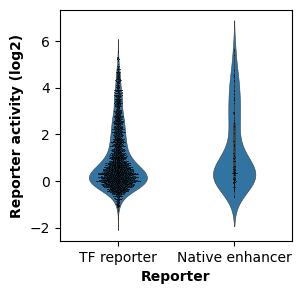

In [4]:
# Figure S1G: Compare TF reporters to native enhancer controls
native_activities = cDNA_df.loc[
    (cDNA_df['condition'] == 'mES_2i_LIF') &
    (cDNA_df['neg_ctrls'] == 'No')]
native_activities = native_activities[['reporter_id', 'tf', 'reporter_activity_minP', 'condition']].drop_duplicates()
native_activities['tf'] = native_activities['tf'].str.replace('_.*', '', regex=True)
native_activities['native_enhancer'] = np.where(native_activities['tf'].isin(['e97', 'e6', 'e19', 'e11', 'e93']), native_activities['tf'], 'tf_reporter')
native_activities['native_enhancer2'] = np.where(native_activities['native_enhancer'] == 'tf_reporter', native_activities['native_enhancer'], 'native_enhancer')

plt.figure(figsize=(3, 3))
# Beeswarm and violin plot using seaborn
sns.swarmplot(data=native_activities, x='native_enhancer2', y=np.log2(native_activities['reporter_activity_minP']), rasterized=True, color='black', size=0.5)
sns.violinplot(data=native_activities, x='native_enhancer2', y=np.log2(native_activities['reporter_activity_minP']), width=0.5, linewidth=0.4)
# Add labels
plt.ylabel("Reporter activity (log2)", weight = "bold")
plt.xlabel("Reporter", weight = "bold")
plt.xticks([0, 1], ["TF reporter", "Native enhancer"])
## Save plot to pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_1-2/native_enhancer_vs_tf_reporter.pdf")
plt.show();

Conclusion: TF reporters are on average less active, but can reach activities as high as native reporters.

---
### Plot median TF reporter activities per cell type

Aim: Show that there are differences in activities between cell types

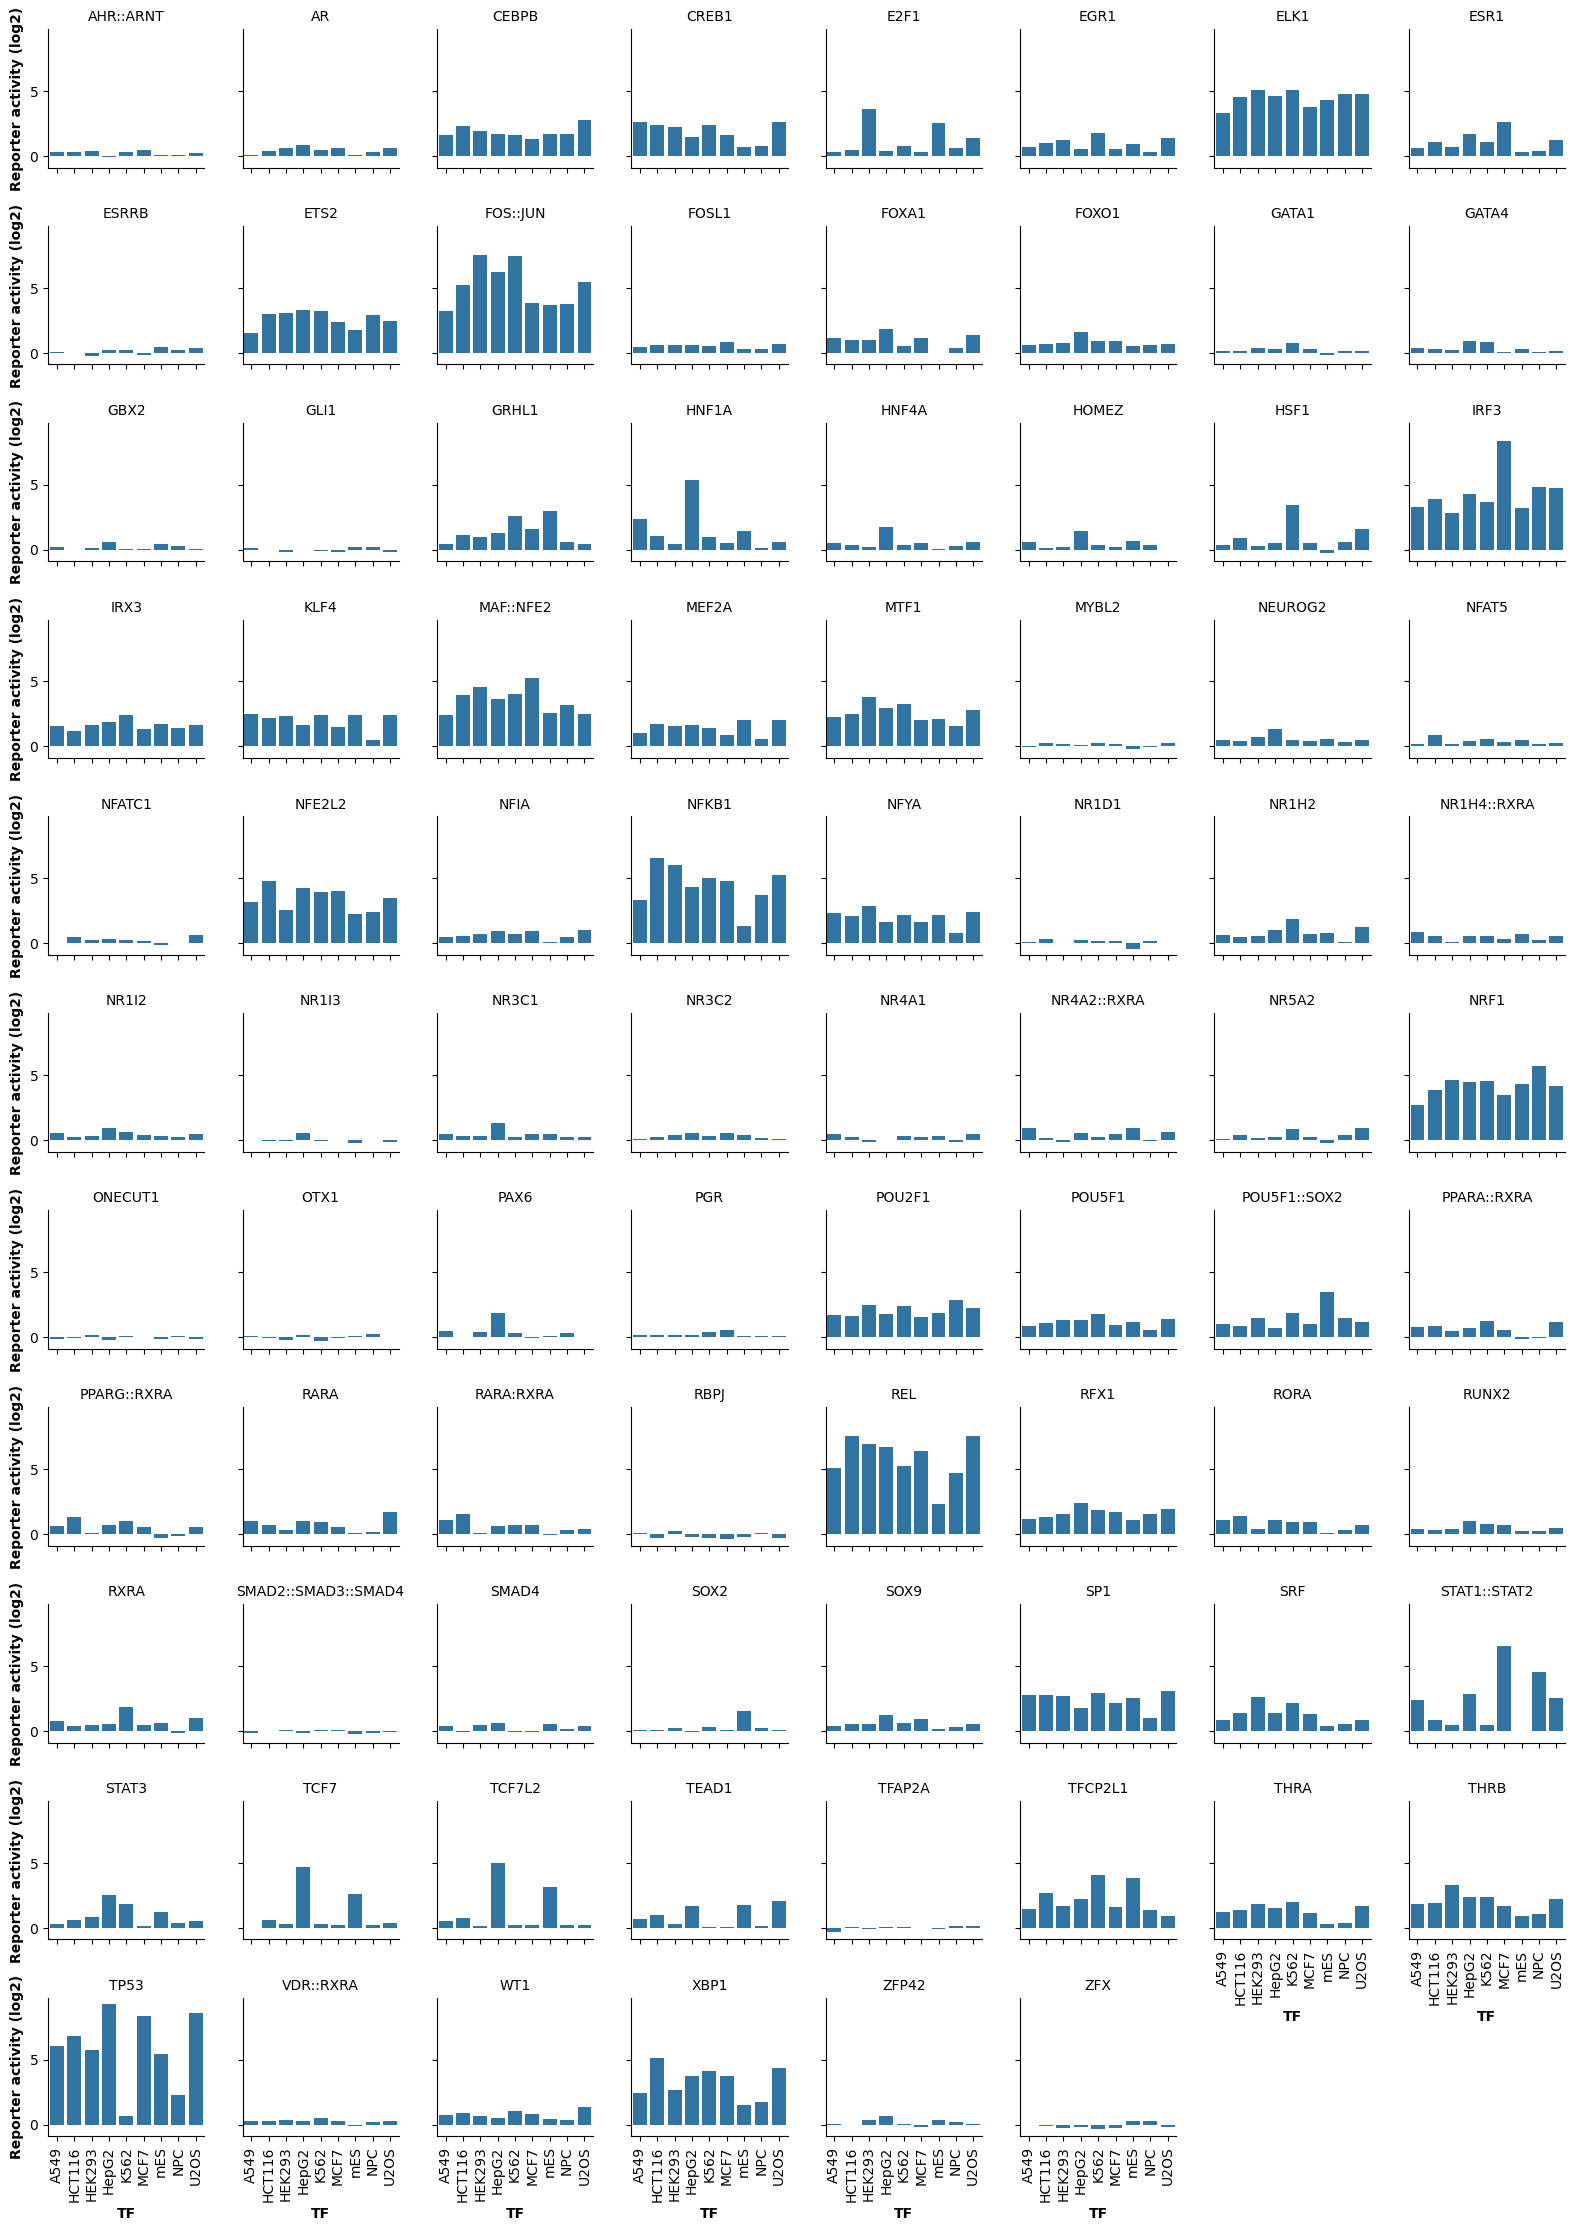

In [7]:
# Figure S2A: Median TF activities in all 9 cell types
tf_activities_median = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['neg_ctrls'] == 'No') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')]
tf_activities_median = tf_activities_median[['tf', 'reporter_activity_minP', 'cell', 'neg_ctrls']].drop_duplicates()
tf_activities_median['reporter_activity_minP'] = tf_activities_median.groupby(['cell', 'tf'])['reporter_activity_minP'].transform('median')
tf_activities_median['reporter_activity_minP'] = np.log2(tf_activities_median['reporter_activity_minP'])
tf_activities_median = tf_activities_median[['reporter_activity_minP', 'tf', 'cell']].drop_duplicates()

# Create a FacetGrid
g = sns.FacetGrid(data=tf_activities_median, col='tf', col_wrap=8, height=2, aspect = 1)

# Map sns.barplot to the FacetGrid
g.map(sns.barplot, 'cell', 'reporter_activity_minP', dodge=False)

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add a legend
g.add_legend()

# Set the titles to only show the variable value
g.set_titles("{col_name}")

# Show the plot
## Add title and axis labels
g.set_axis_labels("TF", "Reporter activity (log2)", weight = "bold")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_1-2/tf_reporter_activity_median.pdf")
plt.show();

Conclusion: There are clear differences between cell types.

---
### Plot all individual TF reporter activities per cell type

Aim: Show that there are differences in activities between cell types + show that there is a spread between reporter variants of the same TF.

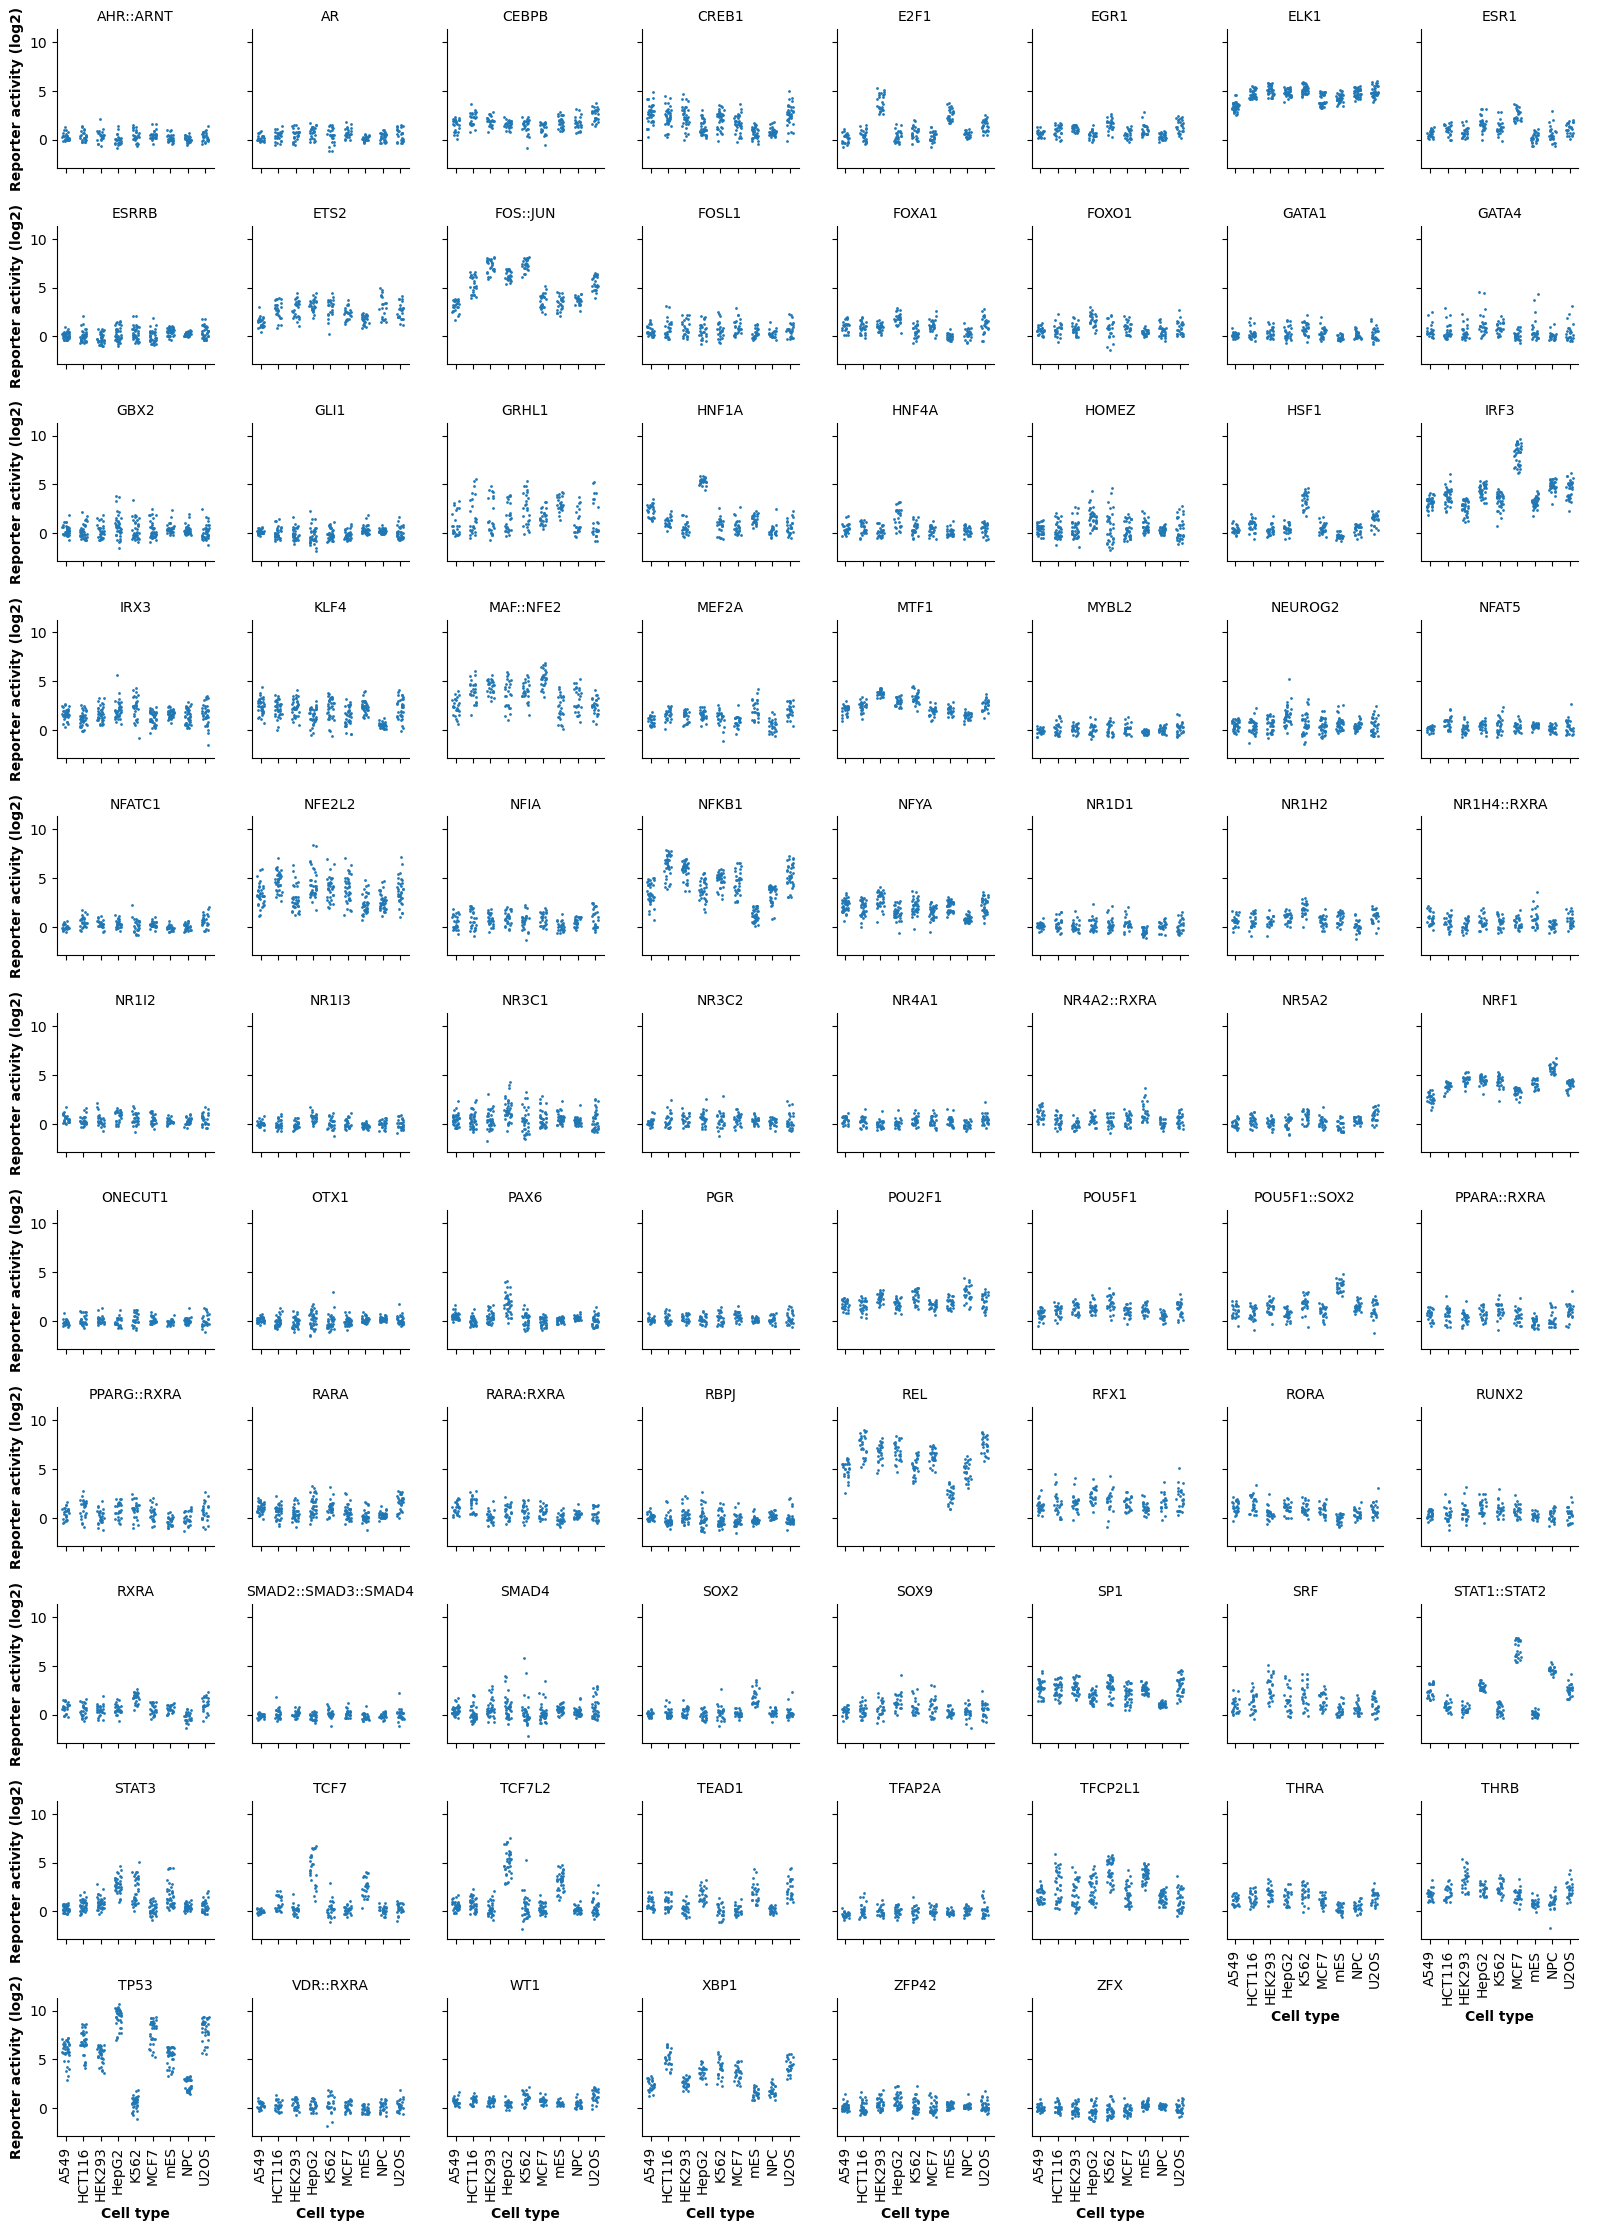

In [22]:
# Figure S2A: Median TF activities in all 9 cell types
tf_activities_median = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['neg_ctrls'] == 'No') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')]
tf_activities_median = tf_activities_median[['tf', 'reporter_activity_minP', 'cell', 'reporter_id']].drop_duplicates()
tf_activities_median['reporter_activity_minP'] = tf_activities_median.groupby(['cell', 'tf', 'reporter_id'])['reporter_activity_minP'].transform('median')
tf_activities_median['reporter_activity_minP'] = np.log2(tf_activities_median['reporter_activity_minP'])
tf_activities_median = tf_activities_median[['reporter_activity_minP', 'tf', 'cell', 'reporter_id']].drop_duplicates()

# Create a FacetGrid
g = sns.FacetGrid(data=tf_activities_median, col='tf', col_wrap=8, height=2, aspect = 1)

# Map sns.swarmplot to the FacetGrid
g.map(sns.stripplot, 'cell', 'reporter_activity_minP', dodge=False, size=2, jitter = 0.2, alpha = .8)

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add a legend
g.add_legend()

# Set the titles to only show the variable value
g.set_titles("{col_name}")

# Show the plot
## Add title and axis labels
g.set_axis_labels("Cell type", "Reporter activity (log2)", weight = "bold")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_1-2/tf_reporter_activity_median_swarm.pdf")
plt.show();

---
### Plot activities of reporters in two cell types - mESC and mNPC
Aim: Get a good overview of reporter activities

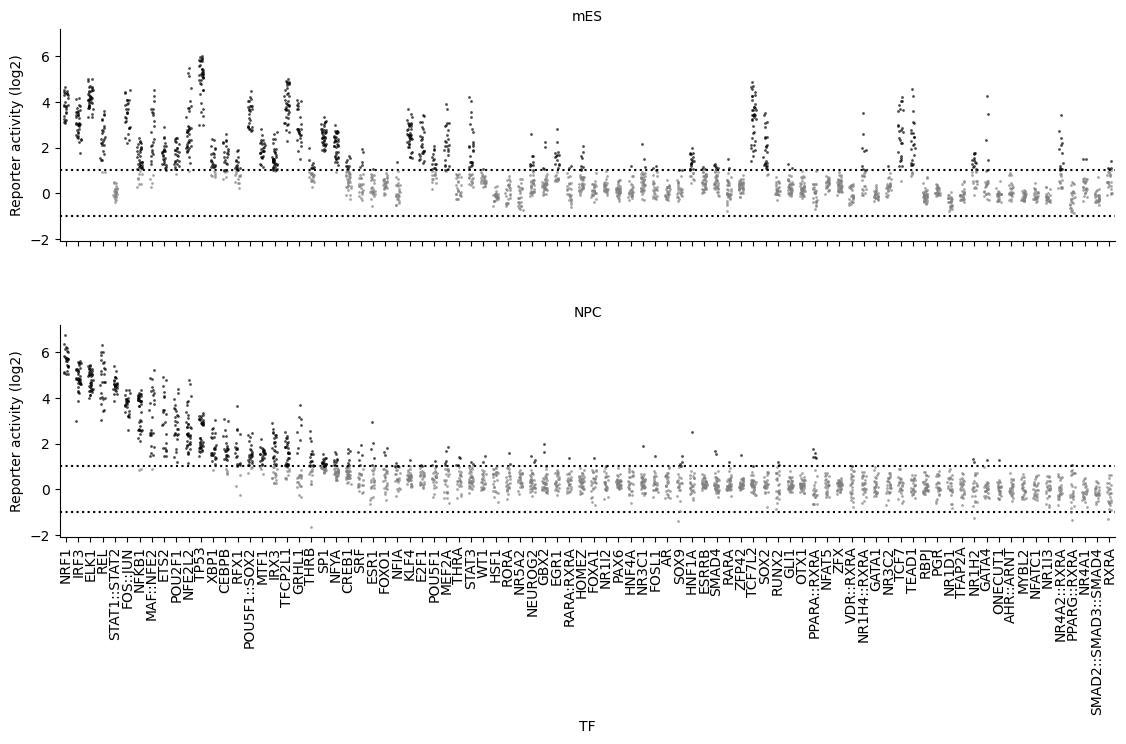

In [33]:
# Filter cDNA_df
cDNA_df_plot = cDNA_df.loc[
    (cDNA_df['neg_ctrls'] == "No") &
    (cDNA_df['commercial_reporter'] == "No") &
    (cDNA_df['hPGK'] == "No") &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == "No")
]
cDNA_df_plot = cDNA_df_plot[['tf', 'reporter_id', 'reporter_activity_minP', 'condition']].drop_duplicates()
cDNA_df_plot['tf'] = cDNA_df_plot['tf'].str.replace('_.*', '', regex=True)
cDNA_df_plot['cell'] = cDNA_df_plot['condition'].str.replace('_.*', '', regex=True)
cDNA_df_plot['reporter_activity_minP'] = np.log2(cDNA_df_plot.groupby(['reporter_id', 'cell'])['reporter_activity_minP'].transform('mean'))
cDNA_df_plot = cDNA_df_plot[['tf', 'reporter_id', 'reporter_activity_minP', 'cell']].drop_duplicates()
cDNA_df_plot['n_tf'] = cDNA_df_plot.groupby(['tf', 'cell'])['tf'].transform('count')
cDNA_df_plot = cDNA_df_plot[cDNA_df_plot['n_tf'] >= 20]
cDNA_df_plot = cDNA_df_plot[cDNA_df_plot['cell'].isin(['NPC', 'mES'])]

# Filter cDNA_df_plot2
cDNA_df_plot2 = cDNA_df_plot[cDNA_df_plot['cell'] == 'NPC']
cDNA_df_plot2['mean_tf_activity'] = cDNA_df_plot2.groupby(['tf', 'cell'])['reporter_activity_minP'].transform('mean')
cDNA_df_plot2 = cDNA_df_plot2[['tf', 'mean_tf_activity']].drop_duplicates()

# Join cDNA_df_plot and cDNA_df_plot2
cDNA_df_plot = pd.merge(cDNA_df_plot, cDNA_df_plot2, on=['tf'])
cDNA_df_plot['sign'] = np.where(cDNA_df_plot['reporter_activity_minP'] > 1, 1, 0)

# Get the order of 'tf' by the descending 'mean_tf_activity'
order = cDNA_df_plot.sort_values('mean_tf_activity', ascending=False)['tf'].unique()

# Create the plot
g = sns.FacetGrid(data=cDNA_df_plot, col='cell', col_wrap=1, height=3, aspect=4, hue = 'sign', palette=['grey', 'black'])
g.map(sns.stripplot, 'tf', 'reporter_activity_minP', order=order, alpha=0.7, size=2, jitter = 0.2)
g.set_titles("{col_name}")
g.set_axis_labels("TF", "Reporter activity (log2)")
g.fig.subplots_adjust(hspace=0.4)

# Add horizontal lines to each facet
for ax in g.axes.flat:
    ax.axhline(y=1, linestyle='dotted', color='black')
    ax.axhline(y=-1, linestyle='dotted', color='black')
    # rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
## Print to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_1-2/tf_reporter_activity_NPC_mES.pdf")
plt.show();